<a href="https://colab.research.google.com/github/jeremysb1/predictive-analytics/blob/main/facebook_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Directory, Libraries, and Data

In [45]:
%cd /content/drive/MyDrive/Business Analyst Course/Predictive Analytics/Facebook Prophet

/content/drive/MyDrive/Business Analyst Course/Predictive Analytics/Facebook Prophet


In [46]:
#import libraries
import numpy as np
import pandas as pd
from fbprophet import Prophet

In [47]:
#get the data
df = pd.read_csv("Udemy_wikipedia_visits.csv")
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,1/1/2016,311,0,0,0
1,1/2/2016,564,0,0,0
2,1/3/2016,517,0,0,0
3,1/4/2016,652,0,0,0
4,1/5/2016,756,0,0,0


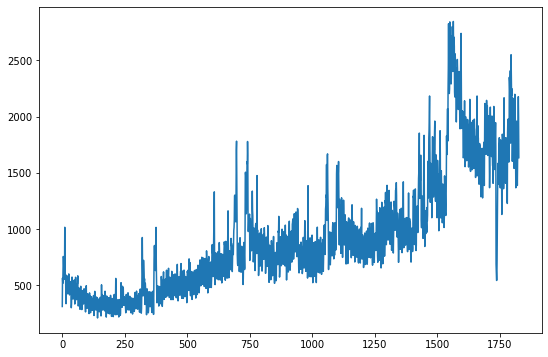

In [48]:
#plot
df.Udemy.plot(figsize = (9,6))

#Data Preparation

In [49]:
#Date Variable
df.Date = pd.to_datetime(df.Date, format = "%m/%d/%Y")
df.Date

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
1822   2020-12-27
1823   2020-12-28
1824   2020-12-29
1825   2020-12-30
1826   2020-12-31
Name: Date, Length: 1827, dtype: datetime64[ns]

In [50]:
#Renaming Variables
df = df.rename(columns = {'Date': 'ds', 'Udemy': 'y'})
df.head()

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0
3,2016-01-04,652,0,0,0
4,2016-01-05,756,0,0,0


#Dynamic Holidays

In [51]:
#Easter
easter_dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': easter_dates,
                       'lower_window': -5,
                       'upper_window': 2})
easter

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2


In [52]:
#Black Friday
bf_dates = pd.to_datetime(df[df['Black Friday'] == 1].ds)
bf = pd.DataFrame({'holiday': 'black_friday',
                   'ds': bf_dates,
                   'lower_window': -7,
                   'upper_window': 5})
bf

,holiday,ds,lower_window,upper_window
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [53]:
#combine events
holidays = pd.concat([easter, bf])
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [54]:
#remove events from main dataframe
df = df.drop(columns = ["Easter", "Black Friday"])
df.head()

,ds,y,Christmas
0,2016-01-01,311,0
1,2016-01-02,564,0
2,2016-01-03,517,0
3,2016-01-04,652,0
4,2016-01-05,756,0


#Facebook Prophet

In [55]:
#training and test split
test_days = 31
training_set = df.iloc[:-test_days,:]
test_set = df.iloc[-test_days:, : ]
print(test_set.head(1))
print(training_set.tail(1))

             ds     y  Christmas
1796 2020-12-01  2393          0
             ds     y  Christmas
1795 2020-11-30  2551          0


In [56]:
#Facebook Prophet Model
m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('Christmas')
m.fit(training_set)

In [57]:
#Coefficient Regressor
from fbprophet.utilities import regressor_coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.295236,-0.295236,-0.295236


#Accuracy Assessment

In [58]:
future = m.make_future_dataframe(periods = test_days,
                                 freq = 'D')
future = pd.concat([future, df.iloc[:,2:]],
                   axis = 1)
future.head(2)

,ds,Christmas
0,2016-01-01,0
1,2016-01-02,0


In [59]:
#forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,black_friday,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-01-01,437.127060,263.613653,656.601798,437.127060,437.127060,0.0,0.0,0.0,0.0,...,-0.023140,-0.023140,-0.023140,0.076082,0.076082,0.076082,0.0,0.0,0.0,460.269171
1,2016-01-02,436.299462,222.703506,603.487187,436.299462,436.299462,0.0,0.0,0.0,0.0,...,-0.177949,-0.177949,-0.177949,0.101768,0.101768,0.101768,0.0,0.0,0.0,403.061592
2,2016-01-03,435.471863,234.311144,628.700372,435.471863,435.471863,0.0,0.0,0.0,0.0,...,-0.140603,-0.140603,-0.140603,0.126597,0.126597,0.126597,0.0,0.0,0.0,429.372462
3,2016-01-04,434.644265,316.850544,731.500686,434.644265,434.644265,0.0,0.0,0.0,0.0,...,0.077068,0.077068,0.077068,0.150164,0.150164,0.150164,0.0,0.0,0.0,533.409143
4,2016-01-05,433.816667,363.122607,749.843779,433.816667,433.816667,0.0,0.0,0.0,0.0,...,0.098608,0.098608,0.098608,0.172086,0.172086,0.172086,0.0,0.0,0.0,551.248388


In [60]:
#retrieve predictions
predictions = forecast.yhat[-test_days:]
predictions[:2]

1796    3023.300851
1797    2802.796041
Name: yhat, dtype: float64

In [61]:
#MAE RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(test_set['y'], predictions))
print(np.sqrt(mean_squared_error(test_set['y'], predictions)))

219.47209415743265
299.14792952647025


#Vizualization

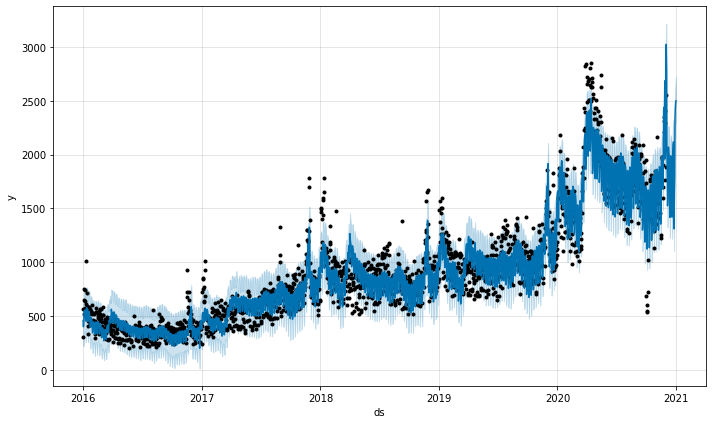

In [62]:
#forecast
m.plot(forecast);

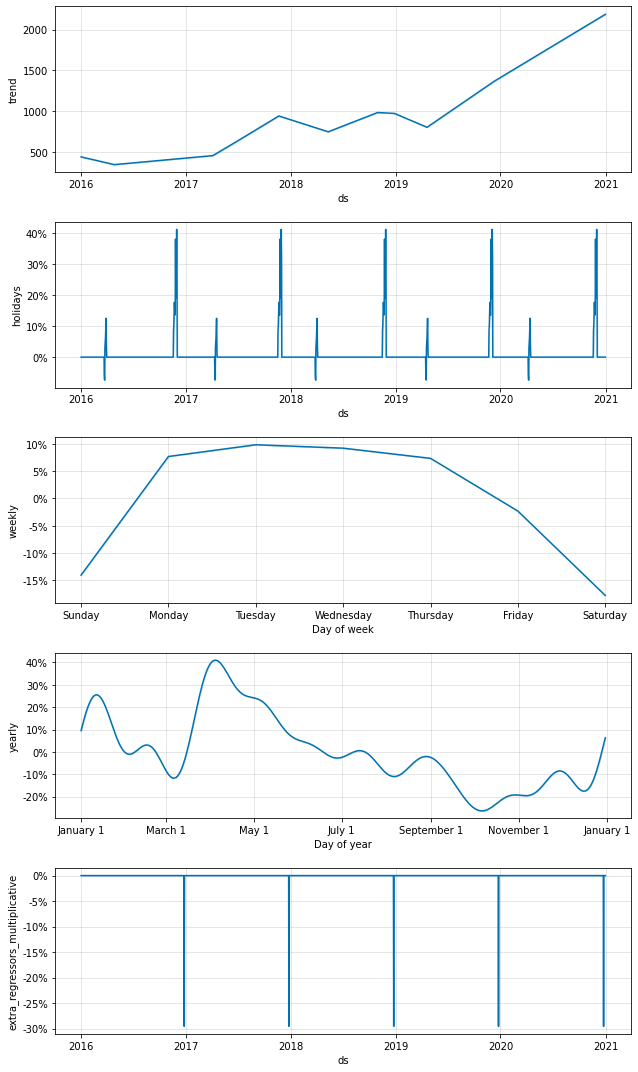

In [63]:
#plot components
m.plot_components(forecast);

#Cross-Validation

In [64]:
#CV
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model = m,
                         horizon = '31 days',
                         initial = '1500 days',
                         parallel = "processes")
df_cv.head()

INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-02-09 12:00:00 and 2020-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f486f13a190>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-10,1420.198954,1299.629703,1547.030766,1611,2020-02-09 12:00:00
1,2020-02-11,1468.451498,1340.568975,1604.792295,1528,2020-02-09 12:00:00
2,2020-02-12,1466.666437,1340.026718,1604.876988,1365,2020-02-09 12:00:00
3,2020-02-13,1436.940868,1312.014182,1562.687741,1487,2020-02-09 12:00:00
4,2020-02-14,1301.940803,1175.312593,1435.356333,1265,2020-02-09 12:00:00


In [65]:
#measure the error
print(mean_absolute_error(df_cv['y'], df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

374.98934197300287
526.6066550954313


#Parameter Tuning

In [66]:
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
list(grid)[:3]

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20}]

In [ ]:
#hyperparameter
rmse = []

#Parameter tuning loop
for params in grid:
  #model
  m = Prophet(growth = 'linear',
              yearly_seasonality = True,
              weekly_seasonality = True,
              daily_seasonality = False,
              seasonality_mode = 'multiplicative',
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor('Christmas')
  m.fit(training_set)

  #cross_validation
  df_cv = cross_validation(model = m,
                           horizon = '31 days',
                           initial = '1500 days',
                           parallel = "processes")

  #get the error
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))

  #store the results
  rmse.append(error)

In [69]:
#Fetch the best parameters
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 5, 'holidays_prior_scale': 10, 'changepoint_prior_scale': 0.1}
